In [ ]:
# We've opted to include type annotations on some functions, but for brevity
# do not include them everywhere.
from typing import Any, Sequence, Union, Optional

import glob
import random
import os
import functools

import numpy as np
import pytorch_lightning as pl

import torch

torch.set_float32_matmul_precision("high")
import torchdata.datapipes as dp
from torchvision import transforms
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex

# We broke a few functions out to their own file. In general this is
# good practice with notebooks.
from utils import label_from_8band, read_tile, one_hot_3d

# Data Loading
In order to load the dataset, we'll use a somewhat recent API in PyTorch called [DataPipes](https://pytorch.org/data/main/torchdata.datapipes.iter.html). The `DataPipes` API allows us to generate a dataset in a functional manner, similar to the `tf.data` API. We don't need to do much here, but it is important that we preprocess the data to make it suitable for the Moonshine model. For the model we are using, the preprocessing is performing simple mean/var standardization.

We also have to accept multiple different transforms, one for the image and one for the mask. This is because the mask transform needs to use a different resizing method from the image.

In [ ]:
from moonshine.preprocessing import get_preprocessing_fn


def read_item(path: str) -> tuple[np.ndarray, np.ndarray]:
    """Read the image and the label mask from a path."""
    fn = get_preprocessing_fn(model="unet", dataset="fmow_full")
    data, _ = read_tile(path)
    data = fn(data)
    data = data.astype(np.float32)

    mask_path = label_from_8band(path, label_type="mask")
    mask = np.load(mask_path).astype(np.uint8)
    mask = one_hot_3d(mask, num_classes=2)

    return data, mask


def remove_missing(path: str) -> bool:
    """If we are missing a label mask file, we'll skip that example."""
    mask_path = label_from_8band(path, label_type="mask")
    if os.path.exists(mask_path):
        return True
    return False


def apply_transforms(row, transform_image, transform_mask):
    """Apply the PyTorch transforms for the DataPipe."""
    return transform_image(row[0]), transform_mask(row[1])


def building_footprint_datapipe(files, transform_image, transform_mask):
    """Create the DataPipe for a set of files."""
    print(f"Got {len(files)} files for this dataset")

    datapipe = dp.iter.IterableWrapper(files)
    datapipe = datapipe.filter(remove_missing)
    datapipe = datapipe.sharding_filter()
    datapipe = datapipe.map(read_item)

    if transform_image and transform_mask:
        transform_fx = functools.partial(
            apply_transforms,
            transform_image=transform_image,
            transform_mask=transform_mask,
        )
        datapipe = datapipe.map(transform_fx)

    return datapipe

# DataLoader
We create a `DataLoader` for our dataset using the datapipe above. This code will also do our train/val splitting. With such a small dataset, it may be better in a production setting to do multifold cross-validation, but for this proof of concept a simple split will be okay.

Also note that for many applications of remote sensing, you may want to be careful with how you split your data. For example, you may want to take into account location (i.e. split by country, etc) and time (i.e. don't include revisited tiles). AGain, for our proof of concept we will do a simple split.

In [ ]:
def train_test_split(
    files: Sequence[str], train_percent: float = 0.8
) -> tuple[list, list]:
    """Very simple train test split, shuffling has a hard coded seed."""
    random.seed(420)
    total = len(files)
    n_train = int(total * train_percent)
    random.shuffle(files)

    return files[0:n_train], files[n_train:]


def get_dataset(files: Sequence[str], split: str = "train") -> DataLoader:
    """Create a dataset for building footprint classification."""
    tfx_image = [
        transforms.ToTensor(),
        transforms.Resize(
            128, interpolation=transforms.InterpolationMode.BILINEAR, antialias=True
        ),
        transforms.RandomCrop((128, 128)),
    ]
    tfx_mask = [
        transforms.ToTensor(),
        transforms.Resize(
            128, interpolation=transforms.InterpolationMode.NEAREST, antialias=None
        ),
        transforms.RandomCrop((128, 128)),
    ]
    datapipe = building_footprint_datapipe(
        files,
        transform_image=transforms.Compose(tfx_image),
        transform_mask=transforms.Compose(tfx_mask),
    )

    return DataLoader(
        dataset=datapipe,
        batch_size=16,
        shuffle=(split == "train"),
        drop_last=True,
        num_workers=4,
        pin_memory=True,
    )

# Model 
Our model is very simple to create using Moonshine! We will use a [UNet50 model](https://moonshineai.readthedocs.io/en/latest/models.html#resnet50-fmow-full) that's designed to be used on the [WorldView](https://earth.esa.int/eogateway/missions/worldview) satellite series. The model can be initialized from scratch, or loaded with pretrained weights from Moonshine's task-agnostic pretraining.

In [ ]:
from moonshine.models.unet import UNet


class BuildingClassifier(torch.nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()

        # Create a blank model based on the available architectures.
        self.backbone = UNet(name="unet50_fmow_full")

        # If we are using pretrained weights, load them here.
        if pretrained:
            self.backbone.load_weights(
                encoder_weights="unet50_fmow_full", decoder_weights="unet50_fmow_full"
            )

        # Run a per-pixel classifier on top of the output vectors.
        self.classifier = torch.nn.Conv2d(32, 2, (1, 1))

    def forward(self, x):
        x = self.backbone(x)
        return self.classifier(x)

# Trainer
We are using [PyTorch Lightning](pytorch-lightning.readthedocs.io/) to simpify the training process. The trainer code is vanilla, with a per-pixel IoU metric as our target metric and Adam optimization.

In [ ]:
class BuildingTrainer(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.jaccard = JaccardIndex(task="multiclass", num_classes=2)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)

        loss = torch.nn.functional.cross_entropy(y_hat, y)
        iou = self.jaccard(y_hat, y[:, 1, :, :])
        self.log("train/loss", loss, on_epoch=True, prog_bar=True)
        self.log("train/iou", iou, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)

        loss = torch.nn.functional.cross_entropy(y_hat, y)
        iou = self.jaccard(y_hat, y[:, 1, :, :])
        self.log("val/loss", loss, on_epoch=True, prog_bar=True)
        self.log("val/iou", iou, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# Train the Model


In [ ]:
DATA_PATH = "/home/nharada/Datasets/spacenet_1_buildings/"


def run_experiment(pretrain=False):
    """Run an experiment with or without pretraining"""
    # Download the files into a folder with 8band and geojson subfolders.
    files = glob.glob(os.path.join(DATA_PATH, "8band/*.tif"))

    # Create a name for Tensorboard
    pretrain_key = "pretrained" if pretrain else "scratch"
    exp_name = f"building_model_{pretrain_key}"

    # Create our datasets.
    train_files, val_files = train_test_split(files)
    train_dataset = get_dataset(train_files, split="train")
    val_dataset = get_dataset(val_files, split="val")

    # We'll use Tensorboard to log our experiments, but this is optional.
    logger = pl.loggers.TensorBoardLogger("tb_logs", name=exp_name)
    trainer = pl.Trainer(
        accelerator="auto",
        max_epochs=50,
        enable_progress_bar=True,
        logger=logger,
    )

    # We'll use the custom lightning trainer, confusingly called a model by the lightning API.
    model = BuildingClassifier(pretrained=pretrain)
    pytrain = BuildingTrainer(model)

    # Train!
    trainer.fit(
        model=pytrain,
        train_dataloaders=train_dataset,
        val_dataloaders=val_dataset,
    )


print("Run experiment without pretraining")
run_experiment(pretrain=False)
print("Run experiment with pretraining")
run_experiment(pretrain=True)

# Results
Once your models have trained, you can open Tensorboard to see the training curves and results.

<div><br>
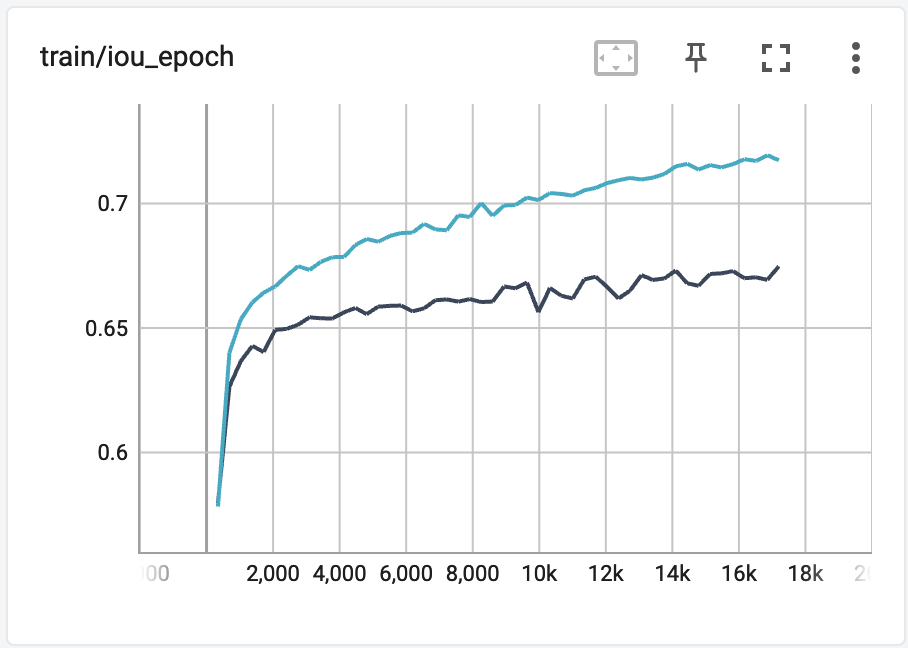
</div>

In the above plot, the black line is our model trained from scratch, while the light blue is trained using the pretrained Moonshine weights. You can see both the amount of overall the pretrained weights makes, as well as how quickly the model improves from the start of training.